In [8]:
from torch.utils.data import DataLoader
import os
import torch
import sys

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import pywt

from auxilary.utils import *
from dataset import nucleiDataset, nucleiValDataset, nucleiTestDataset
from networkModules.modelUnet3p import UNet_3Plus
from auxilary.lossFunctions import *

In [2]:
config = readConfig('configs/config_connic.sys')

In [3]:
trainPaths = config["trainDataset"]
valPaths = config["valDataset"]
testPaths = config["testDataset"]
train_dataset = nucleiDataset(trainPaths, config)
val_dataset = nucleiValDataset(valPaths, config)
test_dataset = nucleiTestDataset(testPaths, config)
trainLoader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_data = DataLoader(val_dataset,batch_size=1,num_workers=4)
test_data = DataLoader(test_dataset,batch_size=1)

In [5]:
model = UNet_3Plus(config)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = weightedDiceLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"], weight_decay=1e-5)

  0%|          | 0/6537 [00:00<?, ?it/s]

torch.Size([16, 256, 256, 2])
[0 1]
SAM ENCODING Shape: torch.Size([16, 256, 64, 64])


  0%|          | 0/6537 [00:05<?, ?it/s]

cA Shape: torch.Size([16, 256, 32, 32])


SystemExit: 0

/home/bishal/projects/SAM-Guided-U-Net/samGEnv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


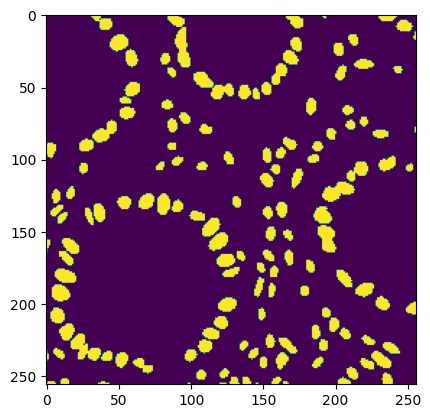

In [9]:
epochs = 1
for epoch in range(epochs):
    for batch in tqdm(trainLoader):
        
        image, mask, samencoding = batch
        mask = mask.squeeze().permute(0,3,2,1)
        print(mask.shape)
        # convert back from one hot encoding
        mask = mask.argmax(dim=3)
        print(np.unique(mask[0]))
        plt.imshow(mask[0].numpy())
        

        print('SAM ENCODING Shape:', samencoding.shape)
        coeef = pywt.dwt2(samencoding.numpy(), 'haar')
        cA, (cH, cV, cD) = coeef
        cA_tensor = torch.from_numpy(cA)

        print('cA Shape:', cA_tensor.shape)

        

        
        sys.exit(0)
        gt = mask.squeeze().float()

        gt = gt.type(torch.float32)

        outputs = model((image.to(device), samencoding.to(device)))
        
        loss = criterion(outputs, gt.to(device))

        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        #print(f"Loss: {loss.item()}")


        pass

    print(f"Epoch {epoch+1}/{epochs} completed.")

torch.Size([1, 256, 64, 64])
